<a href="https://colab.research.google.com/github/DannMacias/ztm_pytorch/blob/main/06_PyTorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<b> PyTorch Transfer Learning </b>

> **Note**: This notebook uses `torchvision`'s new [multi-weight support API (available in `torchvision` v.13+](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/).
>
> *TorchVision has a new backwards compatible API for building models with multi-weight support. The new API allows loading different pre-trained weights on the same model variant, keeps track of vital meta-data such as the classification labels and includes the preprocessing transforms necessary for using the models.*

## What is transfer learning?

**Transfer learning** allow us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

The premise remains: find a well-performing existing model and apply it to your own problem.

### Why use transfer learning?

1. Can leverage an existing model (usually a neural network architecture) proven to work on problems similar to our own.
2. Can leverage a working model which has **already learned** patterns on similar data to our own. This often results in achieving **great results with less custom data**.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-for-foodvision-mini%20.png)

### Whwew to find pretrained models

|**Location**|**What's there?**|**Link(s)**|
|-|-|-|
|**PyTorch domain libraries**|Each of the PyTorch domain libraires come with pretrained models of some from.| [`torchvision.models`](https://pytorch.org/vision/stable/models.html), [`torchtext.models`](https://pytorch.org/text/main/models.html), [`torchrec.models`](https://pytorch.org/torchrec/torchrec.models.html)|
|**HuggingFace Hub**|A series of pretrained models on many different domains from organizations around the world.|https://huggingface.co/models, https://huggingface.co/datasets|
|**`timm` (Pytorch Image Models) library**|Almos all of the latest and greatest computer vision models in PyTorch code.|https://github.com/rwightman/pytorch-image-models|
|**Paperswithcode**|A collection of the latest state-of-the-art machine learning papaers with code implementations attached.|https://paperswithcode.com/|

# 0. Getting setup

We're going to be leveraging some of the Python scripts we created in the previous section.

Specifically, we're going to download the `going_modular` directory from the `pytorch-deep-learning` repository.

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available. `torchinfo` will help later on to give us a visual representtion of our model.

In [1]:
# For this notebook to run with upsated APIs, we need torch 1.12+ and torchvision 0.13+
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory
try:
  from going_modular.going_modular import data_setup, engine
except:
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3196, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 3196 (delta 81), reused 156 (delta 68), pack-reused 3020
Receiving objects: 100% (3196/3196), 643.69 MiB | 25.22 MiB/s, done.
Resolving deltas: 100% (1811/1811), done.
Checking out files: 100% (219/219), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Get data

To see how transfer learning compares to our previous attempts at model building, we'll download the same dataset we've been using for FoodVsion Mini.

Let's write some code to download the [`pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) dataset from the course GitHub and then unzip it.

In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Create Datasets and DataLoaders

Since we've downloaded the going_modular directory, we can use the `data_setup.py` script we created in section 05. PyTorch Going Modular to prepare and setup our DataLoaders.

But since we'll be using a pretrained model from `torchvision.models`, there's a specific transform we need to prepare our images first.

## Creating a transform for `torchvision.models` (manual creation)

> **Note**: As of torchvision v0.13+, there's an update to how data transforms can be created using `torchvision.models`. I've called the previous method "manual creation" and the new method "auto creation". This notebook showcases both.

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Prior to `torchvision` v0.13+, to create a transform for a pretrained model in `torchvision.models`, the documentation started:

> All pre-trained models expect input images normalized in the same way, i.e., mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
>
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.
>
> You can use the following transform to normalize:
>
> ```
> normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])
> ```

We can achieve these transformations with a combination of:
1. **Mini-batches of size `[batch_size, 3, 224, 224]`**: Using `torchvision.transforms.Resize()` to resize images, and `torchvision.utils.data.DataLoader()` to create batches.
2. **Values between 0 & 1**: Using `torchvision.transforms.ToTensor()`
3. **A mean of `[0.485, 0.456, 0.406]`**: The values are across each colour channel, use `torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406])` to adjust the mean of our images.
4. **A standard deviation of `[0.229, 0.224, 0.225]`**: The values are across each colour channel, use `torchvision.transforms.Normalize(std = [0.229, 0.224, 0.225])` to adjust the standard deviation of our images.

> **Question**: *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviation across a subset of images.
>
> We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropiate data distributions (they'll calculate where the mean and standard deviation need to be on their own) but setting them at the start can help our networks achieve better perfomance quicker.


In [6]:
# Create a transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.224])
])

Let's create training and testing DataLoaders.

We can create these using the `create_dataloaders` function from the `data_setup.py` script we created in the previous section.

We'll set `batch_size=32` so our model see's mini-batches of 32 samples at a time.

And we can transform our images using the transform pipeline we created above by setting `transform=manual_transform`.

In [7]:
# Create training and testing DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fca8afc3d50>,
 ['pizza', 'steak', 'sushi'])

## Creating a transform for `torchvision.models` (auto creation)

Above we sar how to manually create a transform for a pretrained model.

But as of `torchvision` v0.13+, an automatic transform creation feature has beed added.

When you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, for example, say we'd like to use:

```
weights = torchvision.model.EfficientNet_B0_Weights.DEFAULT
```

Where,
* `EfficientNet_B0_Weights` is the model architecture weights we'd like to use.
* `DEFAULT` means the *best available* weights (the best performance in ImageNet).



In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

And now to acces the transforms associated with our `weigths`, we can use the `transforms()` method. 

This is essentially saying "get the data transforms that were used to train the `EfficientNet_B0_Weights` on ImageNet".

In [9]:
# Get the transforms used to create our pretrained weigth
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

The benefit of automatically creating a transform through `weights.transforms()` is taht you ensure you're using the same data transformation as the pretrained model used when it was trained.

However, the tradeoff of using automatically created transforms is a lack of customization.

We can use `auto_transforms` to create DataLoaders with `create_dataloader()` just as before.

In [10]:
# Create training and testing DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms,
                                                                               batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fca8b420f90>,
 ['pizza', 'steak', 'sushi'])

# 3. Getting a pretrained model

The whole idea of transfer learning is to **take an already well-performing model on a problem-space similar to yours and then customising it to your use case**.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in [`torchvision.models`](https://pytorch.org/vision/stable/models.html#classification).

|**Architecuture backbone**|**Code**
|-|-|
|[ResNet](https://arxiv.org/abs/1512.03385)|`torchvision.models.resnet50()`...|
|[VGG](https://arxiv.org/abs/1409.1556)|`torchvision.models.vgg16()`|
|[EfficientNet](https://arxiv.org/abs/1905.11946)|`torchvision.models.efficientnet_b0()`|
|[Vision Transformer](https://arxiv.org/abs/2010.11929) (ViT)|`torchvision.models.vit_b_16()`|
|[ConvNext](https://arxiv.org/abs/2201.03545)|`torchvision.models.convnext_tiny()`|


## Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g., `efficientnet_b0()` -> `eficcientnet_b1()` -> `efficientnet_b7()`) means *better performance* but a *larger* model.

> **Some better performing models are too big for some device**, you need to understand this performance vs. speec vs. size tradeoff.

## Setting a pretrained model

The pretrained model we're going to be using is [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0).

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-effnet-b0-feature-extractor.png)

The PyTorch version of this pretrained model is capable of achieving ~77.7% accuracy across ImageNet's 1000 classes.

In [11]:
# Setup the model with pretrained weights and sent to the target device
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

> **Note** In previous versions of `torchvision`, you'd create a pretrained model with code like:
>
> ```
model = torchvision.models.efficientnet_b0(pretrained = True).to(device)
> ```
>
> However, running this using `torchvision` v0.13+ will result in errors.

if we print the model, we get something similar to the following:

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnetb0-model-print-out.png)

Our `efficientnet_b0` comes in three main parts:
1. `features` - A collection of convolutional layers and other various activation layers to learn a base representations of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different **features** of images").
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turn it into a **feature vector**.
3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and beacuse ImageNet has 1,000 classes, `out_features = 1000` is the default).

## Getting a summary of our model with `torchinfo.summary()`

We'll pass in:
* `model` - the model we'd like to get a summary of.
* `input_size` - the shape of the data we'd like to pass to our model, for the case of `efficientnet_b0`, the input size is `(batch_size, 3, 224, 224)`, though [other variants of `efficientnet_bX` have different input sizes](https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93).
  * **Note**: Many modern models can handle input images of varying sizes thanks to [`torch.nn.AdaptiveAvgPool2s()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), this layer adaptively adjusts the `output_size` of a given input as required.
* `col_names` . the various information columns we'd like to see about our model.
* `col_width` - how wide the columns should be for the summary.
* `row_settings` - what features to show in a row.

In [12]:
# Print a summary using torchinfo
summary(model = model,
        input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-unfrozen-layers.png)

For reference, our model from previous sections, TinyVGG had 8,083 parameters vs. 5,288,548 parameters for `efficientnet_b0`, an increase of 654x.

## Freezing the base model and changing the output layer to suit our need

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the `feature` section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnet-changing-the-classifier-head.png)
*You can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original* `torchvision.models.efficientnet_b0()` *comes with* `out_features=1000` *because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need* `out_features=3`.

Let's freeze all of the layers/parameters in the `features` section of our `efficientnet_b0` model.

> **Note**: To freeze layers means to keep them how they are during training. For example, if your model has pretrained layers, to freeze them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad = False`.

For parameters with `requires_grad = False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In [13]:
# Freeze all base layers in the "features" section of the model
for param in model.features.parameters():
  param.requires_grad = False

Let's now adjust the output layer or the `classifier` portion of our pretrained model to our needs.

Right now our pretrained model has `out_features = 1000` because there are 1000 classes in ImageNet.

We can change the `classifier` portion of our model by creating a new series of layers. The current `classifier` consists of:

```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

We'll keep the `Dropout` layer the same using `torch.nn.Dropout(p=0.2, inplace = True)`.

> **Note**: Dropout layers randomly remove connections between two neural network layers with a probability of `p`. For example, if `p=0.2`, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are more general).

And we'll keep `in_features=1280` for our `Linear` output layer nut we'll change the `out_features` value to the length of our `class_names`.


In [14]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names
output_shape = len(class_names)

# Recreate the classifier layer and send it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

Output layer updated, let's get another summary of our model and see what's changed.

In [15]:
# Do a summary "after" freexing the features and changing the output classifier
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-frozen-layers.png)

There's a fair few changes here:

* **Trainable column**
  * You'll see that many of the base layers (the ones in the features portion) have their Trainable value as `False`. This is because we set their attribute `requires_grad=False`. 
  * Unless we change this, these layers won't be updated during furture training.
* **Output shape of `classifier`**
  * The `classifier` portion of the model now has an Output Shape value of `[32, 3]` instead of `[32, 1000]`. 
  * It's Trainable value is also `True`. This means its parameters will be updated during training. In essence, we're using the features portion to feed our `classifier` portion a base representation of an image and then our `classifier` layer is going to learn how to base representation aligns with our problem.
* **Less trainable parameters**
  * Previously there was 5,288,548 trainable parameters. But since we froze many of the layers of the model and only left the `classifier` as trainable, there's now only 3,843 trainable parameters. 
  * Though there's also 4,007,548 non-trainable parameters, these will create a base representation of our input images to feed into our `classifier` layer.

> **Note**: The more trainable parameters a model has, the more compute power/longer it takes to train. Freezing the base layers of our model and leaving it with less trainable parameters means our model should train quite quickly. 
>
> This is one huge benefit of transfer learning, taking the already learned parameters of a model trained on a problem similar to yours and only tweaking the outputs slightly to suit your problem.

# 4. Train model

In [16]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

To train our model, we can use `train()` function we defined in the previous chapter.

In [17]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0977 | train_acc: 0.3828 | test_loss: 0.8856 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9211 | train_acc: 0.6562 | test_loss: 0.7920 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7553 | train_acc: 0.8672 | test_loss: 0.6486 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7376 | train_acc: 0.7070 | test_loss: 0.5954 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6272 | train_acc: 0.7656 | test_loss: 0.6106 | test_acc: 0.8968
[INFO] Total training time: 154.634 seconds


# 5. Evaluate model by plotting loss curves

We can plot the loss curves using the function `plot_loss_curves()` we previously created.

[INFO] Couldn't find helper_functions.py, downloading...


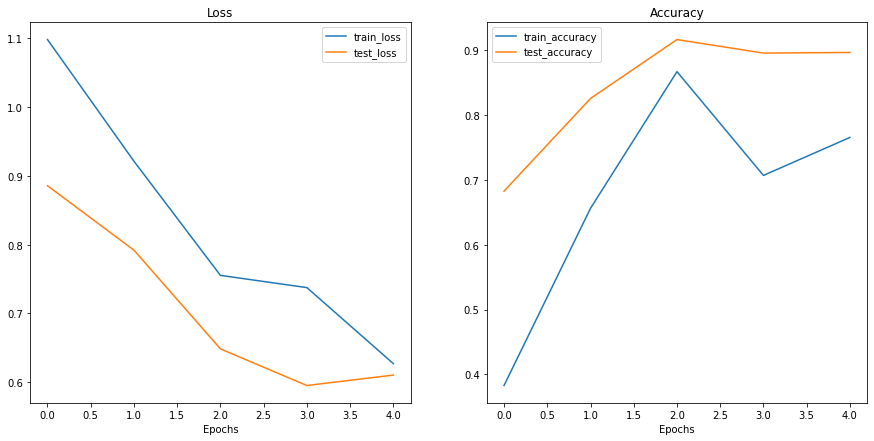

In [18]:
# Get the plot_loss_curves() function from helper_functions.py
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

# 6. Make predictions on images from the test set

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in *same* format as the imgaes our model was trained on.

This means we'll need to make sure our images have:
* **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
* **Same datatype** - If our images are different datatype (e.g., `torch.int8` vs `torch.float32`) we'll get datatypes errors.
* **Same device** - If our images are on a different device to our model, we'll get device errors.
* **Same transformation** - If our model is trained on images that have been transformed in certain way (e.g., normalized with a specific meand and standard deviation) and we try and make predictions on images transformed in a different way, these predictions may be off.

To do all of this, we'll create a function `pred_and_plot_image()` to:
1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with `PIL.Image.open()`.
3. Create a transform for the image.
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with matplotlib and set the title to the prediction label from step 9 and prediction probability from step 8.

In [19]:
from typing import List, Tuple
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  # 2. Open image
  img = Image.open(image_path)

  # 3. Create transformation for image
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])
    ])

  ## Predict on image ##
  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform and add an extra dimension to image [N, C, H, W]
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # 7. Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 9. Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

We can get a list of all the test image paths using `list(Path(test_dir).glob("*/*.jpg"))`.

And we can randomly sample a number of these using Python's `random.sample(population, k)` where `population` is the sequence to sample and `k` is the number of samples to retrieve.

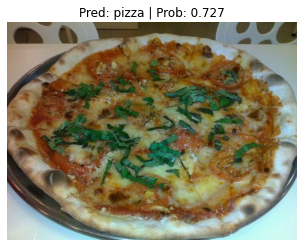

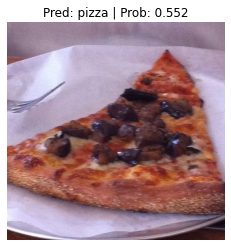

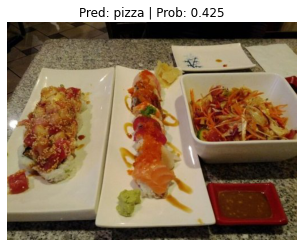

In [25]:
# Get a random list of images paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population = test_image_path_list,
                                       k = num_images_to_plot)

# Make prediction on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model = model,
                      image_path = image_path,
                      class_names = class_names,
                      # transform = weights.transforms(),
                      image_size = (224, 224))

## Making predictions on a custom image



--2022-11-10 23:18:46--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.78.208, 2a04:4e42:12::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.78.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4343742 (4.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a.3’

photo-1588315029754 100%[===================>]   4.14M  --.-KB/s    in 0.08s   

2022-11-10 23:18:46 (50.0 MB/s) - ‘photo-1588315029754-2dd089d39a1a.3’ saved [4343742/4343742]



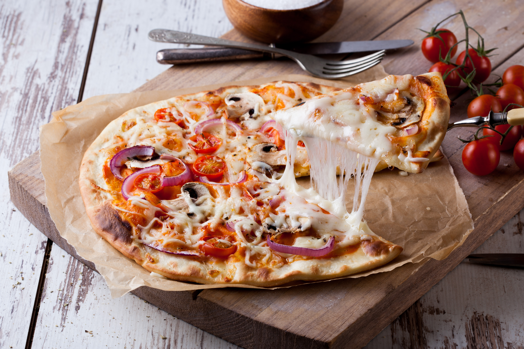

In [35]:
# Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a 
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

from PIL import Image

with Image.open("pizza.jpg") as img:
  # Reduce the image size and width by 10
  (width, height) = (img.width // 10, img.height // 10)
  img_resized = img.resize((width, height))

img_resized

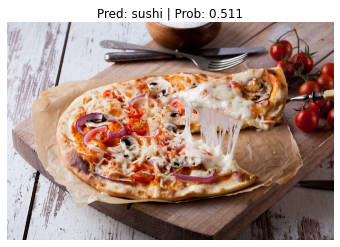

In [32]:
pred_and_plot_image(model = model,
                    image_path = "pizza.jpg",
                    class_names = class_names)